# Assignment 3:  Solid Angle Integration

"Solid angle" is a very useful quantity in physics, amd is a 2 dimensional extension of the concept of angle. For simple angles, the maximum range is $2\pi$ radians, which corresponds to a complete circle; for solid angle the maximum value is $4\pi$ steradians, which corresponds to a complete sphere. Solid angles are used to define the fraction of flux from a source that strikes an object. Inside an object the solid angle is $4\pi$; for a small object far away from a source of flux the solid angle is approximate $\frac{A}{4\pi r^2}$, where A is the cross sectional area of the object and r is the distance between the source and the object.

To determine the solid angle of an object from the origin for an arbitrary geometry, we do the integration:
$$\Omega=\int_{\theta_1}^{\theta_2}\int_{\phi_1(\theta)}^{\phi_2(\theta)}d\phi \sin\theta d\theta\equiv\int_{\cos(\theta_1)}^{\cos(\theta_2)}\int_{\phi_1(\theta)}^{\phi_2(\theta)}d\phi d(\cos\theta) =\int_{\cos(\theta_1)}^{\cos(\theta_2)}(\phi_2(\theta)-\phi_1(\theta)) d(\cos\theta)$$
where the bounds of integration are defined by the shape of the borders of the object. 

Here $r,\theta$,$\phi$ are the spherical coordinates $(x,y,z)=r(\sin\theta\cos\phi,\sin\theta\sin\phi,\cos\phi)$. $\theta_1$ and $\theta_2$ are the minimum and maximum values of $\theta$ over a surface, and $\phi_1(\theta)$ and $\phi_2(\theta)$ are the minimum and maximum values of $\phi$ for a particular $\theta$.

In this problem, we will use our techniques for solving and minimizing to define the borders to integrate the solid angle.  

## A polygon

We can define a polygon by specifying the 2d vector coordinates of its vertices, as well as the $\hat{i},\hat{j}$ unit vectors in the x and y directions in 3d. The z direction is defined from $\hat{k}=\hat{i}\times\hat{j}.$
Determine the vertices of the polynomial that is plotted below. You will need to specify 5 points, since the fifth vertex is the same as the first one.  Plot the polygon in 3d assuming $\hat{i}=(1,0,0), \hat{j}=(0,1,0)$. To plot in 3d projection, use the command 
ax = plt.figure().add_subplot(projection='3d')  

Then plot it if we rotate it by $\pi/6$ about the y-axis, so $\hat{i}=(\cos\frac{\pi}{6},0,\sin\frac{\pi}{6})$ and $\hat{j}$ stays the same.

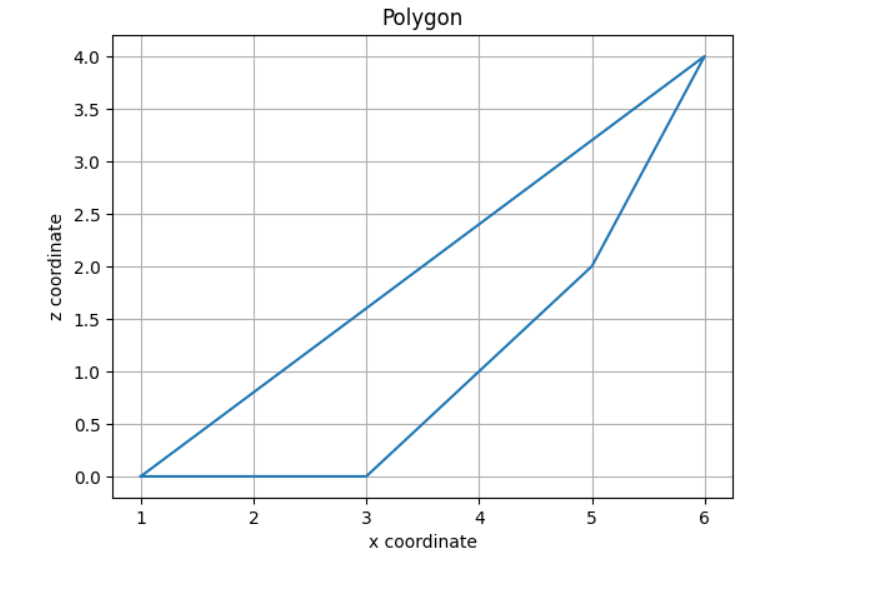




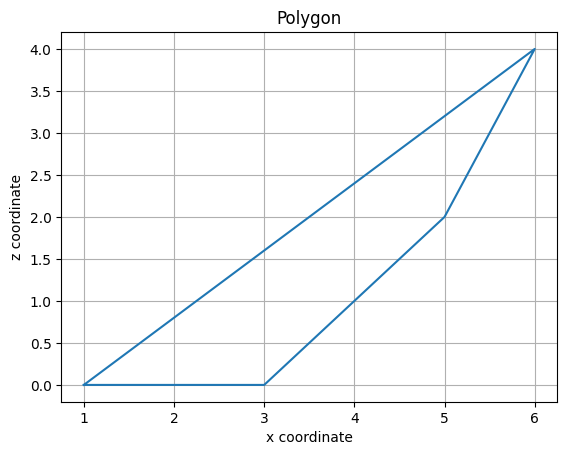

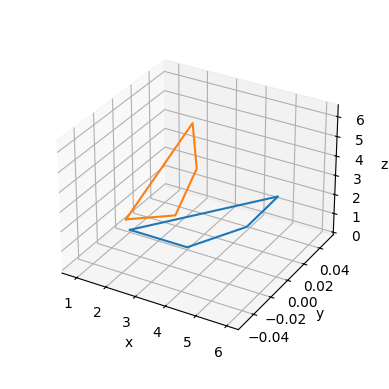

In [112]:
import numpy as np
import math
import matplotlib.pyplot as plt
vertices=np.array([[1,0],[3,0],[5,2],[6,4],[1,0]])
plt.plot(vertices[:,0],vertices[:,1])
plt.grid()
plt.xlabel("x coordinate")
plt.ylabel("z coordinate")
plt.title("Polygon")
plt.show()
i=np.array([1,0,0])
j=np.array([0,1,0])
k=np.cross(i,j)

v3d=vertices@np.stack((i,k)) #vertices is 5x2 array, np.stack is 2x3 array, so multiplication is 5x3

ax = plt.figure().add_subplot(projection='3d')
plt.plot(v3d[:,0],v3d[:,1],v3d[:,2])

i=np.array([math.cos(math.pi/6),0,math.sin(math.pi/6)]);
k=np.cross(i,j)

v3dr=vertices@np.stack((i,k))
plt.plot(v3dr[:,0],v3dr[:,1],v3dr[:,2])
plt.xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_box_aspect(aspect=None, zoom=0.85) 
plt.show()

# Map to the $\cos\theta -\phi$ coordinate system

The solid angle is defined in terms of a "source" point $\vec {x}_0.$ We deal with this by defining a new set of vertices: $$\vec{v}_i=\vec{v}_i'-\vec{x}_0$$ where the original vertices are $\vec{v}_i'$ and the shifted vertices are $\vec{v}_i'$. 

Any point on the polygon is defined by its side, $i$ and a parameter $\alpha$:
     $$\vec{x}=(1-\alpha)\vec{v}_i+\alpha*\vec{v}_{i+1}$$
Here $0<=\alpha<=1$.  

Define python functions:
1. point(alpha,side,polygon) that returns the position of a point on the polygon.
2. ctp(x) That returns np.array([cos theta, phi]) for a point x. Here $\vec{x}=r(\sin\theta \cos \phi, \sin\theta \sin\phi, \cos \theta)$ so $\cos\theta=\frac{x_z}{r}$ and $\phi=\tan^{-1}\frac{y}{x}.$ Note that there is a function arctan2(y,z) in math or numpy that correctly handles the quadrants for the arctan. 
4. plotPoly(polygon,lab) that plots a polygon(defined as a list of vertices) and gives it plot label lab. 

Then run the transform on the polygon and rotated polygon, for source (-1,-1,-1) and plot the result on $\cos\theta-\phi$ axes.

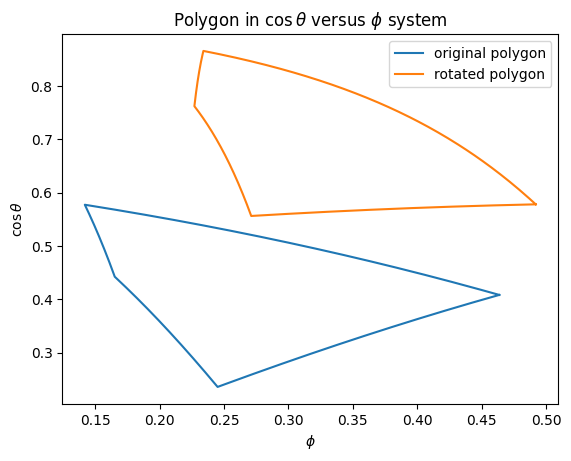

In [128]:

def point(alpha,side,polygon):  #
    return (1-alpha)*polygon[side]+(alpha)*polygon[side+1] 

def ctp(x):
    return [x[2]/np.linalg.norm(x),math.atan2(x[1],x[0])]

origin=np.array([-1,-1,-1])
def plotPoly(polygon,lab):    
    alist=np.linspace(0,1,200)
    ctphi=np.array([[ctp(point(alpha,s,polygon))for alpha in alist] for s in range(len(polygon)-1)]).reshape(-1,2)
    plt.plot(ctphi[:,1],ctphi[:,0],label=lab)
    plt.legend()
    plt.title(r"Polygon in $\cos \theta$ versus $\phi$ system")
    plt.ylabel(r'$\cos \theta $')
    plt.xlabel('$\phi$')    
    return
plt.show()

polyr=v3dr-origin
poly=v3d-origin
plotPoly(poly,'original polygon')
plotPoly(polyr,'rotated polygon')


# The integrand and the integration limits

Write functions:
1. ctside(alpha, ct, side, polygon), which you will solve to find the alpha that corresponds to a given ct (abbreviation for cos theta).
2. phiside(ct,side,polygon) which returns the phi that corresponds to ct, side, polygon.
3. dPhi(ct,polygon) which returns $\phi_2-\phi_1$, the integrand for calculating the solid angle. It should return 0 if ct\<ctmin or ct>ctmax, where ctmin and ctmax correspond to the smallest and largest ct for the polygon.
4. plotDphi(polygon, npoints) to validate your calculations. The should set up a set of npoints between ctmin and ctmax, and for each ct plot the points (phi1, ct), (phi2,ct) which correspond to the left and the right intersections with the polygon.  Overlay this on plotPoly to make sure that your intersection calculations are fine.

Plot the initial and the rotated polygons with plotPoly, and overlay the intersection points.

In [129]:
from scipy.optimize import root_scalar

def ctside(alpha,ct,side,polygon): #function that we can solve to find the alpha that corresponds to cos theta=ct.
    return ctp(point(alpha,side,polygon))[0]-ct

def phiside(ct,side,polygon):
#    print('phiside', ct,side)
    alpha=root_scalar(ctside,bracket=[0,1],args=(ct,side,polygon)).root
    return ctp(polygon[side]*(1-alpha)+polygon[side+1]*alpha)[1]

def dphi(ct,polygon):
    global philist,ctmin,ctmax #so we can access the points
    cts=np.array([ctp(v)[0] for v in polygon])#list of cos thetas
    ctmax=np.max(cts)
    ctmin=np.min(cts)
    if ct<ctmin or ct>ctmax:
        return 0
    else:
        sides=np.asarray(np.nonzero((cts[:-1]-ct)*(cts[1:]-ct)<=0))[0]
#        print('sides=',sides)
        philist=np.sort(np.array([phiside(ct,s,polygon) for s in sides]))
#        print(philist)
        return np.sum(philist[1::2]-philist[0::2])
        

def plotDphi(poly,npoints=10):
    dphi(0,poly)
    ctlist=np.linspace(ctmin,ctmax,npoints)
    ctl=[]
    phi1=[]
    phi2=[]
    for ct in ctlist:
        dphi(ct,poly)
        for p in philist.reshape(-1,2):
            ctl.append(ct)
            phi1.append(p[0])
            phi2.append(p[1])
    plt.plot(phi1,ctl,'o',label='left $\phi$ limit')
    plt.plot(phi2,ctl,'o',label='right $\phi$ limit')
    return

    

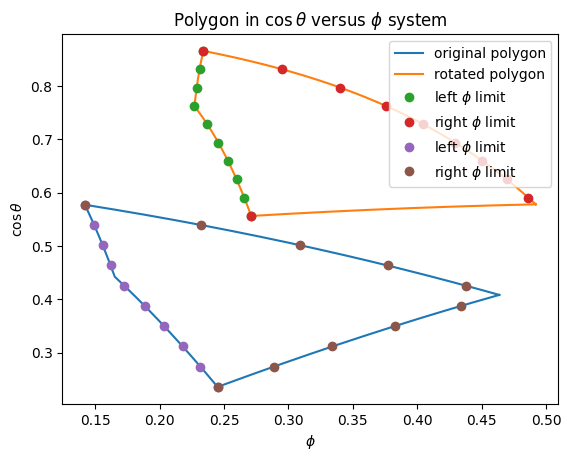

In [130]:
plotPoly(poly,'original polygon')
plotPoly(polyr,'rotated polygon')
plotDphi(polyr)
plotDphi(poly)
plt.legend()



## Now integrate to find the solid angle of the original and rotated polygons.

Write another function, solidAngle(polygon) that integrates and returns the solid angle. What is the solid angle of the initial and rotated polygons?

In [131]:
from scipy.integrate import quad
def solidAngle(polygon,plot=False): # the "plot" argument allows a plot of dphi; it isn't actually asked for in the question but is another way to see that the calculations are working.
    ctpvertices=np.array([ctp(v) for v in polygon])
    ctmin=np.min(ctpvertices[:,0]) #ct integration bounds
    ctmax=np.max(ctpvertices[:,0])
    if plot:
        ctl=np.linspace(ctmin,ctmax)
        plt.plot(ctl,[dphi(ct,polygon) for ct in ctl])
    return quad(dphi,ctmin,ctmax,args=polygon)[0]
    
print(f'Initial polygon solid angle is {solidAngle(poly)} and rotated solid angle is {solidAngle(polyr)}.')

Initial polygon solid angle is 0.05053442547174693 and rotated solid angle is 0.046064651909849715.


Text(0, 0.5, '$\\Delta \\phi$')

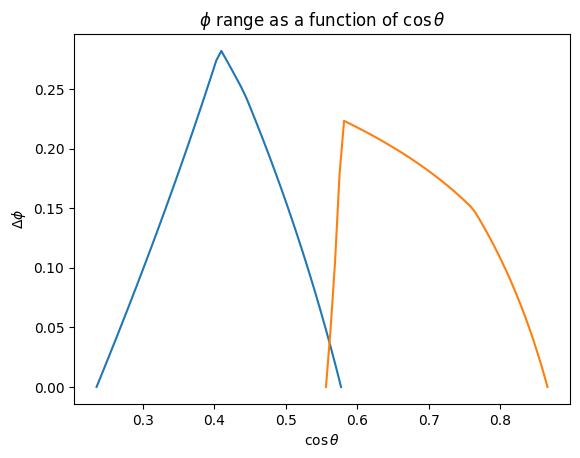

In [132]:
solidAngle(poly,True)
solidAngle(polyr,True)
plt.title(r'$\Delta\phi$ as a function of $\cos\theta$')
plt.title(r'$\phi$ range as a function of $\cos\theta$ ')
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'$\Delta \phi$')


## Modify your routine to work when the maximum or minimum cos theta values are not at vertices.

Now consider your polygon from the reference point (2,-1,0.5).  Plot the polygon in the ct-phi space.  You should notice that the top and the bottom edges are now curved, and that there are solutions that exist above the old ctmax and below the old ctmin definition.
There are different ways to include an extremum, and use this to modify the way we define ctmin, ctmax and to calculation intersection. One way is to add a new vertex at each extremum; then the previous routines will just work and find all the solutions. 

To find the maxima/minima, evaluate dcostheta/dalpha at each of the vertices; if they have opposite signs there is an extremum between. Find the extremum by solving for the case when the derivative is zero. Add that vertex to the polynomial to get a change polynomial. To do this, I wrote a function addvertices(polygon) which outputs a new polygon with the additional vertices. 
To validate, plot the cos theta, phi points for dphi and show that we are including the new extremum.

Calculate the solid angle.


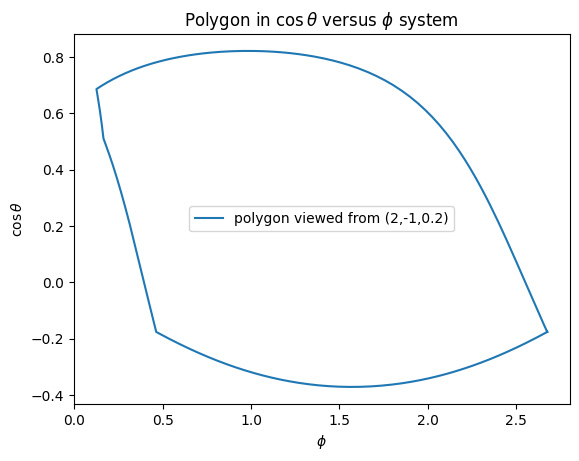

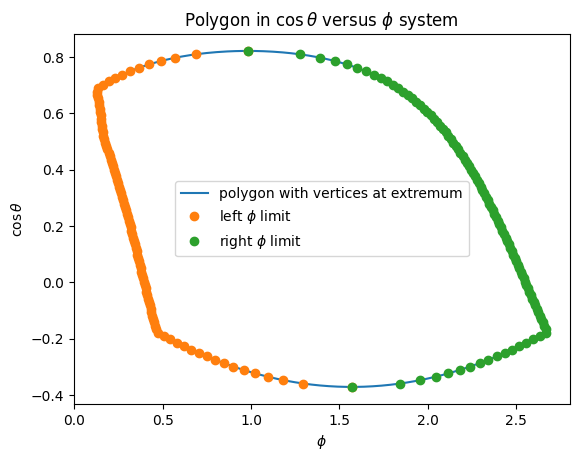

The solid angle is 2.2202442166350824


Text(0, 0.5, '$\\Delta \\phi$')

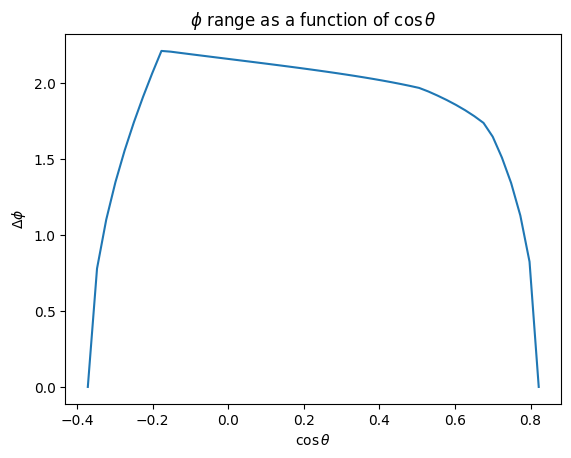

In [133]:
from scipy.optimize import root_scalar
poly2=v3d-np.array([2,-.5,0.2])
plotPoly(poly2,'polygon viewed from (2,-1,0.2)')
plt.legend()
plt.show()
def dctdalpha(alpha,side,polygon):
    ap=alpha+5e-6
    am=alpha-5e-6
    return (ctp(point((ap),side,polygon))[0]-ctp(point(am,side,polygon))[0])/(ap-am)

def addvertices(polygon):
    der0=np.array([dctdalpha(0,s,polygon)for s in range(len(polygon)-1)])  #derivative at alpha=0
    der1=np.array([dctdalpha(1,s,polygon)for s in range(len(polygon)-1)]) #derivative at alpha=1
    breakSides=np.asarray(np.nonzero(der0*der1<0))[0] #sides where the derivatives have opposite signs
#    print('\n\n breakSides:',breakSides)
    if len(breakSides)==0:
        return polygon
    i=0
    j=0
    newV=[]
    breakSides=np.append(breakSides,len(breakSides)+len(polygon))
    for k in range(len(breakSides)+len(polygon)-1):
        if i<=breakSides[j]:
            newV.append(polygon[i])
#            print('appended ',i)
            i=i+1
        else:
            s=breakSides[j]
            newV.append(point(root_scalar(dctdalpha,bracket=[0,1],args=(s,polygon)).root,s,polygon))
#            print('appended extremum ',j)
            j=j+1
    return np.array(newV)

newPoly=addvertices(poly2)
plotPoly(newPoly,'polygon with vertices at extremum')
plotDphi(newPoly,npoints=100)
plt.legend()


plt.show()
print(f'The solid angle is {solidAngle(newPoly,True)}')
plt.title(r'$\phi$ range as a function of $\cos\theta$ ')
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'$\Delta \phi$')

    

## A 3d box

Polyhedra consist of a set of polygon faces connected to form a 3d object. We can calculate the solid angle of a 3d object by looking at the union of the projections of the faces into the $\phi-\cos\theta$ plane, and then integrating.  Start by plotting the faces of a box with x-length 6, y-width 1, z-height 2, and one corner at the origin.  Observe the box from the poing (-1,-2,-3).

Define the polyhedron as a list or array of polygons, and plot the 6 polygons in the $\phi-\cos\theta$ plane.

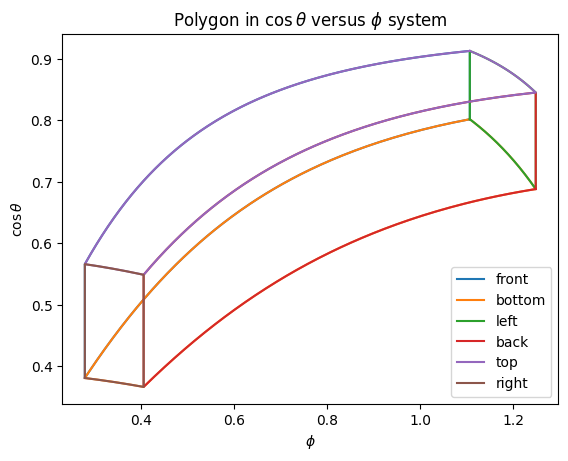

In [137]:
l=6
w=1
h=2
origin=np.array([-1,-2,-3])
labels=['front','bottom','left','back','top','right']

faces=np.array([[[0,0,0],[l,0,0],[l,0,h],[0,0,h],[0,0,0]], #front
                [[0,0,0],[l,0,0],[l,w,0],[0,w,0],[0,0,0]], #bottom
                [[0,0,0],[0,0,h],[0,w,h],[0,w,0],[0,0,0]], #left
                [[0,w,0],[l,w,0],[l,w,h],[0,w,h],[0,w,0]], #back
                [[0,0,h],[l,0,h],[l,w,h],[0,w,h],[0,0,h]], #top
                [[l,0,0],[l,0,h],[l,w,h],[l,w,0],[l,0,0]]]) #right
for i,p in enumerate(faces):
    plotPoly(p-origin,labels[i])
plt.show()



## Rotate the polygon 
Now rotate the polygon with the coordinate transformation $\hat{i}=(1,-3,0)/\sqrt{10},\hat{j}=(3,1,0)/\sqrt{10},\hat{k}=(0,0,1))$. You want to rotate the vertices, but not the source point, so rotate before shifting.
To rotate we can either define a matrix R, with rows i,j,k and do $v'=vR$ or define $R^T$ with columns (i,j,k) and do $v'=R^Tv$.  In either case, you will need to loop through the vertices to do the matrix multiplication.
Then shift the origin, and apply your function to add vertices to include maxima/minima between vertices to each of the polygons.

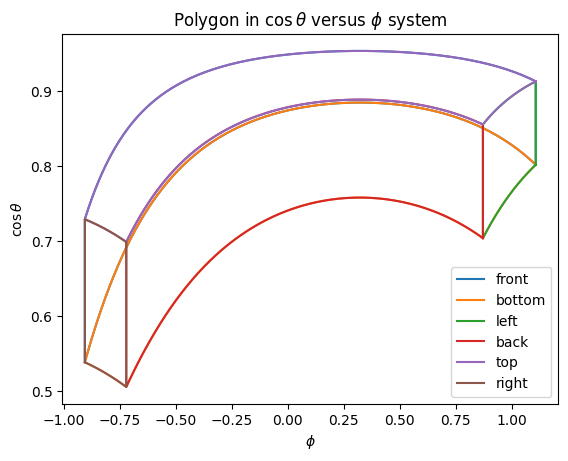

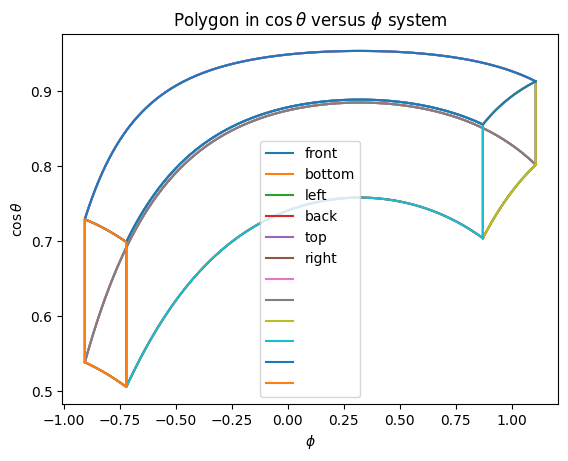

In [138]:
i=np.array([1,-3,0])/np.sqrt(10)
j=np.array([3,1,0])/np.sqrt(10)
k=np.array([0,0,1])
R=np.array([i,j,k])
RT=R.transpose()

rFaces=[]
rtf=[]
for p in faces:
    pr=[]
    prt=[]
    for v in p:
        pr.append(v@R)
        prt.append(RT@v)
    rFaces.append(pr)
    rtf.append(prt)
for i,f in enumerate(rFaces):
    plotPoly(f-origin,labels[i])

plt.show()
for i,f in enumerate(rtf):
    plotPoly(f-origin,labels[i])
addrf=[]
for f in rFaces:
    addrf.append(addvertices(f-origin))

for f in addrf:
    plotPoly(f,' ')

# Solid angle of a polyhedron

Now define a function dPhiPoly(ct, polyhedron) that calculates $\phi_2-\phi_1$ for a polyhedron.  You run into the complication that the different polygons that make up the polyhedron can overlap. In addition, just as for polygons, there could be multiple ranges of $\phi$ for a single ct. There is a "trick" to handle this- if we have $\phi_{1i}$ and $\phi_{2i}$ as the endpoints of the i-th segment, the overall endpoints $\phi_1,\phi_2$ are the only points which are not in any of the segments-- ie. $\phi_{1i}<\phi_1<phi_{2i}$ for all i; and similarly for the right endpoint.  If there are multiple segments you will need to generalize this test.

Then calculate the solid angle of the polyhedron.  

The solid angle is 0.4580191165154217, which is 0.036448003212006065 of 4pi


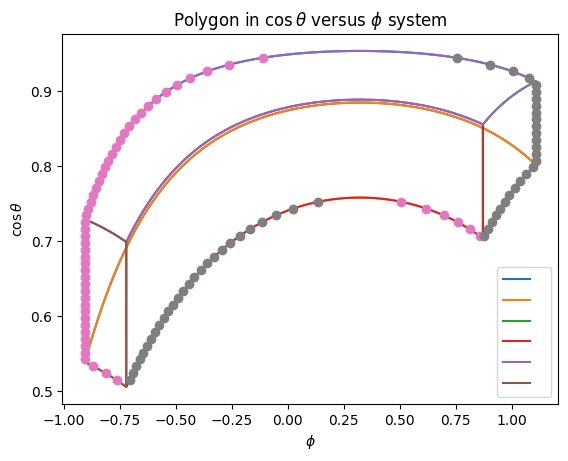

In [142]:
def dPhiPoly(ct, polyhedron):
    global left, right
    phis=[]
    for f in polyhedron:
        if dphi(ct,f)>0:
            for p in philist.reshape(-1,2):  # allow there to be more than one range for a given phi
                phis.append(p)
    phis=np.array(phis)
    left=[]
    right=[]
    for s in phis:
        if np.sum((phis[:,0]<s[0])&(phis[:,1]>s[0]))==0:
            left.append(s[0])
        if np.sum((phis[:,0]<s[1])&(phis[:,1]>s[1]))==0:
            right.append(s[1])
    left=np.unique(left)
    right=np.unique(right)
    return np.sum(right-left)

def solidAngle2(polyhedron):
    minima=[]
    maxima=[]
    for f in polyhedron:
        ctpvertices=np.array([ctp(p) for p in f])
        minima.append(np.min(ctpvertices[:,0])) #ct integration bounds
        maxima.append(np.max(ctpvertices[:,0]))
    ctmin=np.min(minima)
    ctmax=np.max(maxima)
    ctlist=np.linspace(ctmin,ctmax)
    cl=[]
    p0=[]
    p1=[]
    for c in ctlist:
        if dPhiPoly(c,polyhedron)>0:
            for l,r in zip(left,right):
                cl.append(c)
                p0.append(l)
                p1.append(r)
    for f in polyhedron:
        plotPoly(f,' ')
    plt.plot(p0,cl,'o')
    plt.plot(p1,cl,'o')
            
    return quad(dPhiPoly,ctmin,ctmax,args=polyhedron,limit=100)

sa=solidAngle2(addrf)[0]
print(f'The solid angle is {sa}, which is {sa/(4*np.pi)} of 4pi')
        
